In [ ]:
# Making imports convenient
import sys
import os
PATH=os.getcwd().split('/notebooks')[0]
sys.path.insert(1, PATH)

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset, concatenate_datasets
import transformers
from sklearn.model_selection import StratifiedKFold

from transformers import AutoTokenizer, DataCollatorWithPadding,AutoModelForSequenceClassification,TrainingArguments,Trainer

from src.utils.myutils import *
import yaml
from tqdm import tqdm
import logging
import json
import warnings
import random
import pandas as pd

logging.disable(logging.ERROR)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

CS_DATA_PATH = PATH + '/data/CS/processed/'
CONFIG_PATH = PATH + '/src/utils/config.yaml'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_name = 'fav-kky/FERNET-C5'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False,padding=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

BATCH_SIZE = 32

In [23]:
model_path = '/home/horyctom/bias-detection-thesis/src/models/trained/wiki_balanced.pth'

## Data

In [24]:
cw_hard = load_dataset('csv',data_files = CS_DATA_PATH + 'CW-HARD/cw-hard.csv')['train']
cwnc = load_dataset('csv',data_files = CS_DATA_PATH + 'CWNC/cwnc.csv')['train']
wikibias = load_dataset('csv',data_files = CS_DATA_PATH + 'WikiBias/wikibias.csv')['train']

In [25]:
wikinpov = concatenate_datasets([cw_hard,cwnc,wikibias]).shuffle(seed=42)

In [26]:
unbalanced = wikinpov
balanced = resample(wikinpov)

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

## Unbalanced

In [18]:
tokenized = preprocess_data(unbalanced,tokenizer,'sentence')
tokenized = tokenized.train_test_split(0.2)

  0%|          | 0/19 [00:00<?, ?ba/s]

In [19]:
pretraining_args = TrainingArguments(
    num_train_epochs=5,
    per_device_train_batch_size=BATCH_SIZE,  
    per_device_eval_batch_size=BATCH_SIZE,
    eval_steps=50,
    logging_steps=50,
    save_steps=400,
    disable_tqdm = False,
    warmup_steps=0,
    save_total_limit=1,
    evaluation_strategy="steps",
    weight_decay=0.1,
    output_dir = './',
    learning_rate=2e-5)

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.to(device)
trainer = Trainer(model,pretraining_args,train_dataset=tokenized['train'],data_collator=data_collator,
                  tokenizer=tokenizer,eval_dataset=tokenized['test'],compute_metrics=compute_metrics_eval)
trainer.train()

Step,Training Loss,Validation Loss,F1
50,0.688100,0.658581,0.413793
100,0.656600,0.593583,0.534646
150,0.610800,0.581097,0.639612
200,0.582000,0.580093,0.650623
250,0.576000,0.564931,0.620416
300,0.560600,0.567797,0.650673
350,0.566500,0.559251,0.634466
400,0.575600,0.567772,0.639531
450,0.566800,0.569634,0.636392
500,0.522300,0.640821,0.611820


TrainOutput(global_step=2365, training_loss=0.434216161510153, metrics={'train_runtime': 837.2231, 'train_samples_per_second': 90.352, 'train_steps_per_second': 2.825, 'total_flos': 3307875868532220.0, 'train_loss': 0.434216161510153, 'epoch': 5.0})

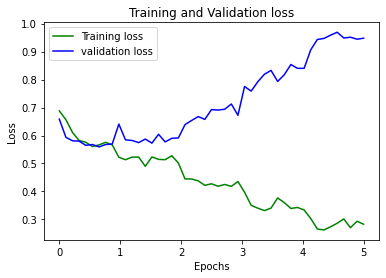

In [21]:
 plot_losses(pd.read_csv('wikinpov_unbalanced.loss',sep='\t'))

## Balanced

In [27]:
tokenized = preprocess_data(balanced,tokenizer,'sentence')
tokenized = tokenized.train_test_split(0.2)

  0%|          | 0/17 [00:00<?, ?ba/s]

In [28]:
pretraining_args = TrainingArguments(
    num_train_epochs=3,
    per_device_train_batch_size=BATCH_SIZE,  
    per_device_eval_batch_size=BATCH_SIZE,
    eval_steps=50,
    logging_steps=50,
    save_steps=400,
    disable_tqdm = False,
    warmup_steps=0,
    save_total_limit=1,
    evaluation_strategy="steps",
    weight_decay=0.1,
    output_dir = './',
    learning_rate=2e-5)

In [29]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.to(device)
trainer = Trainer(model,pretraining_args,train_dataset=tokenized['train'],data_collator=data_collator,
                  tokenizer=tokenizer,eval_dataset=tokenized['test'],compute_metrics=compute_metrics_eval)
trainer.train()

Step,Training Loss,Validation Loss,F1
50,0.704300,0.681517,0.358681
100,0.681400,0.669684,0.671339
150,0.666800,0.597389,0.656934
200,0.601700,0.577068,0.679520
250,0.587300,0.572322,0.691812
300,0.589000,0.567729,0.699342
350,0.583800,0.573837,0.644622
400,0.579700,0.564654,0.707550
450,0.551000,0.580439,0.650602
500,0.520900,0.593930,0.625576


TrainOutput(global_step=1221, training_loss=0.538036973626764, metrics={'train_runtime': 423.9784, 'train_samples_per_second': 92.028, 'train_steps_per_second': 2.88, 'total_flos': 1700246250842640.0, 'train_loss': 0.538036973626764, 'epoch': 3.0})

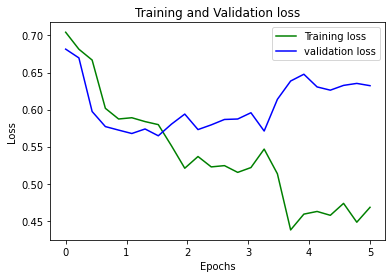

In [30]:
 plot_losses(pd.read_csv('wikinpov_balanced.loss',sep='\t'))

## Train on all

In [31]:
tokenized = preprocess_data(balanced,tokenizer,'sentence')

In [32]:
pretraining_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=32,  
    logging_steps=100,
    save_steps=400,
    disable_tqdm = False,
    warmup_steps=0,
    save_total_limit=1,
    weight_decay=0.1,
    output_dir = './',
    learning_rate=2e-5)

In [34]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.to(device)
trainer = Trainer(model,pretraining_args,train_dataset=tokenized,data_collator=data_collator,
                  tokenizer=tokenizer)
trainer.train()

torch.save(model.state_dict(),model_path)

Step,Training Loss
100,0.698800
200,0.635800
300,0.599500
400,0.599500
500,0.579100
600,0.530000
700,0.514000
800,0.548600
900,0.528500
1000,0.516300
